## Pre-trained GloVe on Twitter data

In [1]:
# importing libraries
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import pandas as pd
import csv
import numpy as np

from statistics import mean
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Constants

In [2]:
TOP_N = 30
KEYS = { \
    "offensive": set(),
    "abusive": set(),
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    # adding another one - sexist    
    "sexist": set()
}
FIXED_KEYS = list(KEYS.keys())

In [3]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 

for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexist': {'sexist'}}

Define some functions

In [4]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [5]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [6]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [7]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [9]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

## Loading a model

We are using pretrained model, trained on a twitter dataset. Dataset contained 2 billion tweets, 27 billion tokens and 25 dimensional vectors.

More models are accessable on this link: http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [11]:
# These two files 'glove.twitter.27B.25d.txt' and 'twitter.txt' can both be found in the folder 'Pretrained_Glove_embeddings' 
# which is located on our GDrive.
glove2word2vec(glove_input_file="../models/glove.twitter.27B.25d.txt", \
               word2vec_output_file="../models/twitter.txt")

(1193514, 25)

In [12]:
glove_model = KeyedVectors.load_word2vec_format("../models/twitter.txt", binary=False)

In [13]:
word_clusters, embedding_clusters = getSimilarWords(glove_model)

{'offensive', 'offens'} -- offense
{'abusive', 'abus'} -- abusing
{'abusive', 'abus'} -- abused
{'cyberbulli', 'cyberbullying'} -- cyberbulling
{'racist'} -- racists
{'homophob', 'homophobic'} -- homophobe
{'homophob', 'homophobic'} -- homophobes
{'slur'} -- slurs
{'harras', 'harrasment'} -- harrassment
{'threat'} -- threats
{'insult'} -- insults
{'insult'} -- insulting
{'hostile', 'hostil'} -- hostility


In [14]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,sexist
0,defensive,irresponsible,oversharing,superficial,sexist,sexist,self-deprecating,accusations,delikanlıları,egregious,violence,classify,hypocritical,deny,dysfunctional,homophobic
1,defense,controlling,intimidation,detestable,homophobic,racist,depictions,misogynist,sananların,arbitrary,facing,demonize,idiotic,recognize,chaotic,idiotic
2,controversial,threatening,kangacrew,cliché,ignorant,misogynist,perpendicular,molestation,yavşaklığın,over-the-top,attacks,perpetuate,degrading,refer,idle,racist
3,shocking,elderly,censoring,heterosexual,pathetic,bigot,well-developed,transphobic,asılır,impactful,corruption,appease,perverted,admit,degenerate,misogynistic
4,questionable,kidnapping,cyber-bullying,homosexual,clueless,misogynistic,small-minded,birther,accen,symbolic,assault,simulate,naive,recognise,superstitious,hypocritical
5,foul,cheating,limbaugh,antisocial,disrespectful,idiotic,strident,sodomy,ibneliğin,dubious,outrage,differentiate,gullible,unlike,reckless,bigoted
6,officiating,exposing,condemning,anorexia,immature,bigoted,pernicious,plagiarism,know-it-alls,unsavory,laws,constitute,cynical,offend,thriving,misogynist
7,opponent,homophobic,inciting,hetero,idiots,hypocritical,limitantes,defamation,kuvvetini,menacing,political,scrutinize,judgmental,understand,secretive,stereotypical
8,blatant,insulting,criminalizing,mediocre,retarded,racists,well-intentioned,anti-union,eleştirme,innocuous,issues,misrepresent,ignorant,judge,ruthless,moronic
9,tactics,demanding,impeaching,hipster,idiot,abusive,gülümserken,bigot,rodent,objectionable,deadly,publicize,uneducated,disrespect,unorganized,pretentious


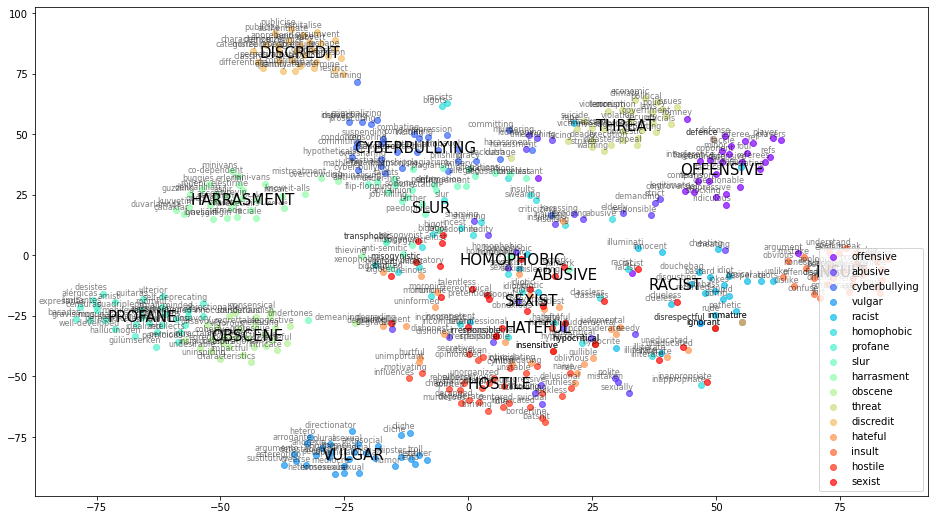

In [15]:
plotTSNE("", word_clusters, embedding_clusters, "SimilarWordsSNE_pretrained.png")

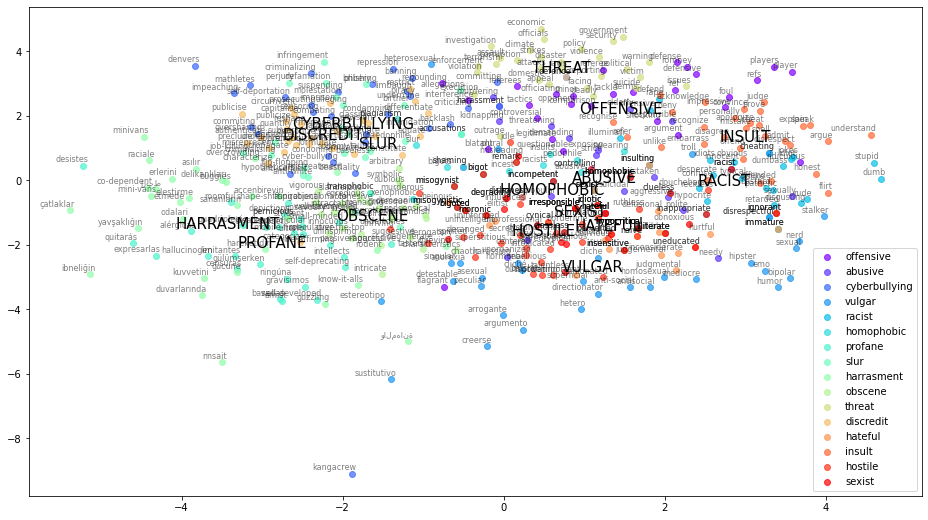

In [16]:
plotMDS("", word_clusters, embedding_clusters, "SimilarWordsMDS_pretrained.png")

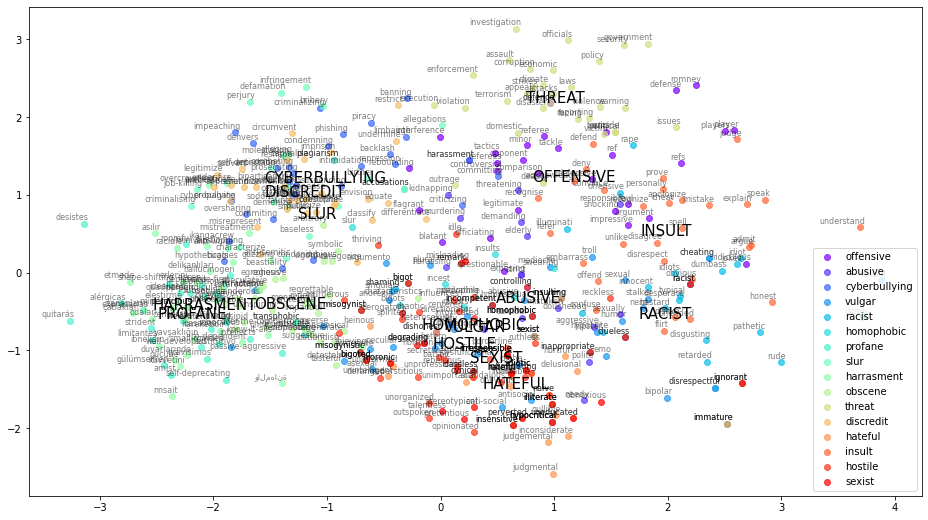

In [17]:
plotPCA("", word_clusters, embedding_clusters, "SimilarWordsPCA_pretrained.pdf")

### Word analogy

In [18]:
glove_model.most_similar(positive=['white', 'nigger'], negative=['black'])

[('clown', 0.8726812601089478),
 ('chick', 0.8701307773590088),
 ('goon', 0.868828296661377),
 ('thot', 0.8643379211425781),
 ('nigguh', 0.8562196493148804),
 ('tramp', 0.8527854084968567),
 ('faggot', 0.852377712726593),
 ('fag', 0.8505725264549255),
 ('hoe', 0.8494992256164551),
 ('motherfucker', 0.846732497215271)]

In [19]:
glove_model.most_similar(positive=['black', 'trash'], negative=['white'])

[('garbage', 0.916708767414093),
 ('dirty', 0.8990354537963867),
 ('bull', 0.8943390250205994),
 ('straight', 0.883106529712677),
 ('flip', 0.8828834295272827),
 ('strip', 0.8769538402557373),
 ('dick', 0.8733822107315063),
 ('ass', 0.8720723390579224),
 ('blow', 0.8718814849853516),
 ('hype', 0.8664205074310303)]

In [20]:
glove_model.most_similar(positive=['trump', 'obama'], negative=['cool'])

[('netanyahu', 0.9022107720375061),
 ('cuomo', 0.8839709758758545),
 ('assange', 0.878002941608429),
 ('kerry', 0.8724615573883057),
 ('christie', 0.8713017702102661),
 ('jpmorgan', 0.8683613538742065),
 ('reagan', 0.8667344450950623),
 ('snowden', 0.8665890693664551),
 ('hillary', 0.8662517666816711),
 ('ahmadinejad', 0.8651611804962158)]